<a href="https://colab.research.google.com/github/SheshamJoseph/Deep-Learning-with-Tensorflow-ZTM/blob/main/human_or_horses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Humans or Horses...

Here we build a Convolution Neural Network to distinguish whether the content of an image is human or a horse. The dataset used for this project contains over a thousand 300x300 pixel images of horses and humans in different poses. This notebook uses the steps in the book **AI and Machine Learning for Coders**, chapter 3 from page 42, as a guide

### First fetch the dataset and visualize a few images

In [1]:
import zipfile
# Download the training data
!wget -P /content/train_data https://storage.googleapis.com/learning-datasets/horse-or-human.zip

train_zip = "/content/train_data/horse-or-human.zip"

# Unzip the data
zip_ref = zipfile.ZipFile(train_zip, 'r')
zip_ref.extractall(path="/content/train_data/")

zip_ref.close()

--2024-01-08 23:54:07--  https://storage.googleapis.com/learning-datasets/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.4.207, 74.125.200.207, 74.125.130.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.4.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/content/train_data/horse-or-human.zip’

horse-or-human.zip  100%[===================>] 142.65M  21.7MB/s    in 7.8s    

2024-01-08 23:54:15 (18.2 MB/s) - ‘/content/train_data/horse-or-human.zip’ saved [149574867/149574867]



In [2]:
# Walk thtough the folder directories
import os

train_dir = "/content/train_data/"
for dirpath, dirnames, filenames in os.walk(train_dir):
    print(f"There are {len(dirnames)} folders and {len(filenames)} images in {dirpath}")

There are 2 folders and 1 images in /content/train_data/
There are 0 folders and 527 images in /content/train_data/humans
There are 0 folders and 500 images in /content/train_data/horses


In [3]:
# getting the class names
import numpy as np
import pathlib

!rm -rf /content/train_data/horse-or-human.zip
dir = pathlib.Path(train_dir)
class_names = np.array([item.name for item in dir.glob('*')])
print(class_names)

['humans' 'horses']


In [4]:
# Creating a function to randomly plot images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def plot_random_images(target_dir, class_names=class_names):
    plt.figure(figsize=(10,7))
    for i in range(9):
        # setup the target directory
        target_class = random.choice(class_names)
        target_folder = target_dir + target_class
        # select an image
        random_image = random.sample(os.listdir(target_folder), 1)
        image = mpimg.imread(target_folder+'/'+random_image[0])
        # plot the image
        plt.subplot(3, 3, i+1)
        plt.imshow(image)
        plt.title(target_class)
        plt.axis('off')


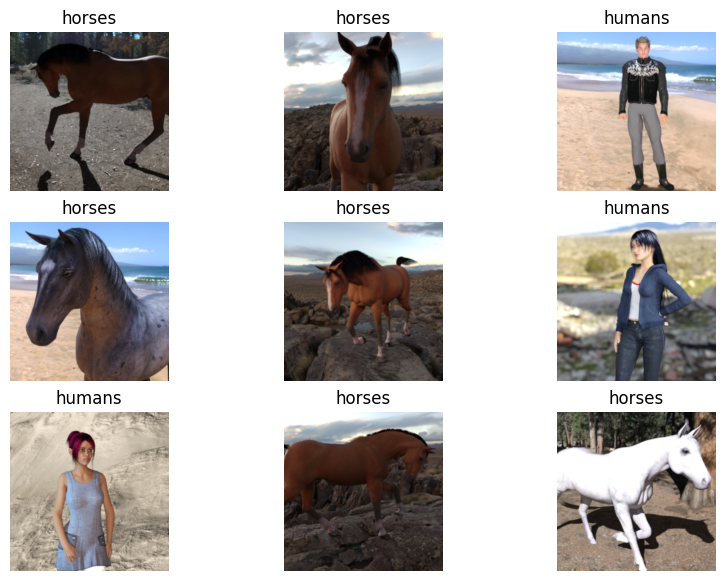

In [5]:
plot_random_images(train_dir)

In [6]:
# Let's also get our validation data
!wget -P /content/valid_data https://storage.googleapis.com/learning-datasets/validation-horse-or-human.zip

valid_zip = "/content/valid_data/validation-horse-or-human.zip"

# Unzip the data
zip_ref = zipfile.ZipFile(valid_zip, 'r')
zip_ref.extractall(path="/content/valid_data/")

zip_ref.close()

--2024-01-08 23:54:17--  https://storage.googleapis.com/learning-datasets/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.4.207, 74.125.200.207, 74.125.130.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.4.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11480187 (11M) [application/zip]
Saving to: ‘/content/valid_data/validation-horse-or-human.zip’

validation-horse-or 100%[===================>]  10.95M  6.81MB/s    in 1.6s    

2024-01-08 23:54:19 (6.81 MB/s) - ‘/content/valid_data/validation-horse-or-human.zip’ saved [11480187/11480187]



In [7]:
# see the contents of the valid data directory
!rm -rf /content/valid_data/validation-horse-or-human.zip
valid_dir = "/content/valid_data/"
for dirpath, dirnames, filenames in os.walk(valid_dir):
    print(f"There are {len(dirnames)} folders and {len(filenames)} images in {dirpath}")

There are 2 folders and 0 images in /content/valid_data/
There are 0 folders and 128 images in /content/valid_data/humans
There are 0 folders and 128 images in /content/valid_data/horses


## Next we load the the data and create a dataset for our model

In [8]:
import tensorflow as tf
import keras
from keras.utils import image_dataset_from_directory

image_size = (300, 300)
batch_size = 32
train_dataset = image_dataset_from_directory(
    train_dir,
    image_size=image_size,
    label_mode='binary',
    shuffle=True,
    seed=42,
    batch_size=batch_size
)

test_dataset = image_dataset_from_directory(
    valid_dir,
    image_size=image_size,
    label_mode='binary',
    shuffle=True,
    seed=42,
    batch_size=batch_size
)

Found 1027 files belonging to 2 classes.
Found 256 files belonging to 2 classes.


In [9]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

## Done with loading the data...
Now we build a baseline model and try to beat what ever results we get. For now we will train without augumenting the images.

In [11]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Rescaling, Flatten

# set random seed
tf.random.set_seed(42)

# create the model, following TinyVGG's architecture on the CNN Explainer website
model_1 = Sequential([
    Rescaling(1./255, input_shape=(300, 300, 3)),
    Conv2D(10, (3,3), activation='relu'),
    Conv2D(10, (3,3), activation='relu'),
    MaxPool2D(),
    Conv2D(10, (3,3), activation='relu'),
    Conv2D(10, (3,3), activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation='sigmoid')
])

# compile the model
model_1.compile(loss='binary_crossentropy',
                optimizer="adam",
                metrics=['accuracy'])

# fit the model
hist_1 = model_1.fit(train_dataset, epochs=5,
                     steps_per_epoch=len(train_dataset),
                     validation_data=test_dataset,
                     validation_steps=len(test_dataset))

Epoch 1/5
33/33 [==============================] - 13s 172ms/step - loss: 0.7377 - accuracy: 0.6738 - val_loss: 0.5972 - val_accuracy: 0.6484
Epoch 2/5
33/33 [==============================] - 2s 67ms/step - loss: 0.2842 - accuracy: 0.9065 - val_loss: 1.2844 - val_accuracy: 0.6641
Epoch 3/5
33/33 [==============================] - 2s 60ms/step - loss: 0.1158 - accuracy: 0.9620 - val_loss: 1.2841 - val_accuracy: 0.7500
Epoch 4/5
33/33 [==============================] - 2s 59ms/step - loss: 0.0452 - accuracy: 0.9903 - val_loss: 2.0704 - val_accuracy: 0.6953
Epoch 5/5
33/33 [==============================] - 2s 59ms/step - loss: 0.0277 - accuracy: 0.9961 - val_loss: 2.2505 - val_accuracy: 0.7383


In [12]:
# evaluate the model
model_1.evaluate(test_dataset)

8/8 [==============================] - 0s 30ms/step - loss: 2.2505 - accuracy: 0.7383


[2.2505245208740234, 0.73828125]

<Axes: >

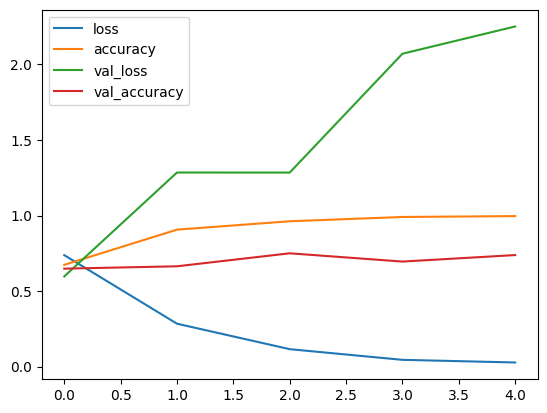

In [14]:
# Check loss curves
import pandas as pd

pd.DataFrame(hist_1.history).plot()

Now to build a function that takes in an image and predicts which class it belongs, we need another function to load and prepare the image for the model